In [1]:
!pip install mlflow #library that helps to log runs and model parameters

     |████████████████████████████████| 14.1 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 38.3 MB/s eta 0:00:01     |████████████████████            | 675 kB 38.3 MB/s eta 0:00:01
     |████████████████████████████████| 328 kB 37.2 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 50.3 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 2.2 MB/s  eta 0:00:01
     |████████████████████████████████| 77 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 84 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 2.8 MB/s  eta 0:00:01


  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158154 sha256=32532a33adb05fa961700d2692cb551dfa44dd5d0aad18372acbc47efd1cf608
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.14.1-py3-none-any.whl size=100576 sha256=2d0677cba7db6345e42d3e2e14c24fd2a7d34e20196ba82e857c0f21d2e31f98
  Stored in directory: /root/.cache/pip/wheels/7f/d9/25/baefac3eda0e7dbf143008d2b9865e0d923d4b7306136244fe
  Created wheel for prometheus-flask-exporter: filename=prometheus_flask_exporter-0.18.1-py3-none-any.whl size=17157 sha256=472ca594be46bfe7b1fae61ec16b2f73ceb81cf114e7c02f4775e688b2c9bf94
  Stored in directory: /root/.cache/pip/wheels/c4/b6/b5/e76659f3b2a3a226565e27f0a7eb7a3ac93c3f4d68acfbe617
Successfully built alembic databricks-cli prometheus-flask-exporter
  Attempting uninstall: alembic
    Found existing installation: alembic 1.4.3
    Uninstalling a

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os

import mlflow.tensorflow
from mlflow.tensorflow import autolog

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.callbacks as C
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import Callback 
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers as O
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import VGG16, ResNet50

from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['stanford-car-dataset-by-classes-folder', 'sf-dl-car-classification', 'previous-iteration-model']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


In [3]:
!nvidia-smi #check gpu

Wed Jan 13 08:29:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup

In [34]:
EPOCHS               = 100 # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED          = 42
autolog() # логгируем эксперименты

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "./" # рабочая директория

# optimizers
adadelta = O.Adadelta(learning_rate = LR)
adam = O.Adam(learning_rate = LR)
adagrad = O.Adagrad(learning_rate = LR)
rmsprop = O.RMSprop(learning_rate = LR)

checkpoint =  C.ModelCheckpoint('best_model.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
# scheduler = LearningRateScheduler(get_triangular_lr)
callback_reduce_lr = C.ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.5,
                                       min_lr=1e-10,
                                       patience=0,
                                       verbose=1)
early_stopping_callback = C.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    restore_best_weights=True)


callbacks_list = [early_stopping_callback, checkpoint, callback_reduce_lr]

# Useful Functions

In [31]:
def get_history(model):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

In [32]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-3enl79ef
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
# Настроим аугментации

import tensorflow as tf
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

AUGMENTATIONS = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=1),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
])

# Pre-training on Stanford Cars Dataset

In [8]:
#pre_training setup
data_path = '../input/stanford-car-dataset-by-classes-folder'
nb_train_samples = 8144
nb_validation_samples = 8041
n_classes = 196

In [9]:
import csv
names = []

with open(data_path + '/names.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter=';')
    for row in csvReader:
        names.append(row[0])

print(names[:10])

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012']


In [10]:
#Pre-training data loaders
train_data_dir = data_path + '/car_data/car_data/train'
test_data_dir = data_path + '/car_data/car_data/test'


train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        preprocess_input=None)

train_gen = train_datagen.flow_from_directory(
    train_data_dir,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_gen = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 7018 images belonging to 196 classes.
Found 1116 images belonging to 196 classes.


In [11]:
def pretrain_model():
    base = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
    # new head installation
    x = base.output
    
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # and a logistic layer
    predictions = Dense(n_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base.input, outputs=predictions)
    model.load_weights('../input/previous-iteration-model/best_model.hdf5')
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    history = model.fit_generator(
        train_gen,
        steps_per_epoch = len(train_gen),
        validation_data = test_gen, 
        validation_steps = len(test_gen),
        epochs = EPOCHS,
        callbacks = callbacks_list)
    model.save('../working/model_last.hdf5')
    model.load_weights('./best_model.hdf5')
    return model

# Data

In [12]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

Id  Category
0  100155.jpg         0
1  100306.jpg         0
2  100379.jpg         0
3  100380.jpg         0
4  100389.jpg         0

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [14]:
print(train_df.Category.value_counts())
print(f'There are {train_df.Category.nunique()} unique categories')

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64
There are 10 unique categories


In [15]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train', '__notebook_source__.ipynb']


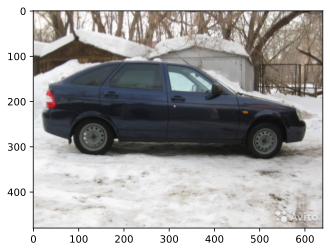

(640, 480)

In [16]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size



# Data Generators

In [17]:
# dataloaders
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        preprocess_input=None)

test_datagen = ImageDataAugmentor(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

aug_sub_generator =  train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


# Base model training

In [18]:
base_model = pretrain_model()

94773248/94765736 [==============================] - 1s 0us/step


2021/01/13 08:36:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '316c7dd0154f4494b951b062163800fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


110/110 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9962
Epoch 00001: val_accuracy improved from -inf to 0.70520, saving model to best_model_m.hdf5
110/110 [==============================] - 156s 1s/step - loss: 0.0612 - accuracy: 0.9962 - val_loss: 1.3356 - val_accuracy: 0.7052


In [ ]:
# ML

# ML

In [35]:
model = Sequential([Model(inputs = base_model.inputs,
                         outputs = base_model.layers[-2].output),
                   Dense(10,'softmax')])

In [ ]:
# for layer in model.layers[:19]:
#     layer.trainable = False

In [36]:
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [37]:
# необходимо переписать этот кусок для небольшого количества эпох
# num_iterations = 10000
# stepsize = 1000
# base_lr = 0.00001
# max_lr = 0.001
# lr_trend = list()
# # Используем циклический learning rate
# def get_triangular_lr(epoch, base_lr, stepsize = stepsize, max_lr = max_lr):
#     """Given the inputs, calculates the lr that should be applicable for this iteration"""
#     cycle = np.floor(1 + iteration/(2  * stepsize))
#     x = np.abs(iteration/stepsize - 2 * cycle + 1)
#     lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
#     return lr



# # Посмотрим как именно меняется lr
# for iteration in range(num_iterations):
#     lr = get_triangular_lr(iteration, base_lr, stepsize,  max_lr)
#     # Update your optimizer to use this learning rate in this iteration
#     lr_trend.append(lr)

# plt.plot(lr_trend)

In [38]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

2021/01/13 09:45:43 INFO mlflow.utils.autologging_utils: tensorflow autologging will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow to the MLflow run with ID '02f6b6bd76fa42029c1f0f63b74b87f9'
2021/01/13 09:45:44 WARNING mlflow.utils.autologging_utils: MLflow issued a warning during tensorflow autologging: "/opt/conda/lib/python3.7/site-packages/mlflow/tensorflow.py:747: UserWarning: Logging to MLflow failed: Changing param values is not allowed. Param with key='opt_learning_rate' was already logged with value='1e-07' for run ID='02f6b6bd76fa42029c1f0f63b74b87f9'. Attempted logging new value '0.0001'."


Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.7180
Epoch 00001: val_accuracy improved from -inf to 0.80635, saving model to best_model.hdf5
207/207 [==============================] - 149s 718ms/step - loss: 0.8279 - accuracy: 0.7180 - val_loss: 0.5911 - val_accuracy: 0.8064
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8600
Epoch 00002: val_accuracy improved from 0.80635 to 0.83856, saving model to best_model.hdf5
207/207 [==============================] - 146s 706ms/step - loss: 0.3914 - accuracy: 0.8600 - val_loss: 0.4923 - val_accuracy: 0.8386
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.9036
Epoch 00003: val_accuracy improved from 0.83856 to 0.85058, saving model to best_model.hdf5
207/207 [==============================] - 145s 701ms/step - loss: 0.2759 - accuracy: 0.9036 - val_loss: 0.4319 - val_accuracy: 0.8506
Epoch 4/100
207/207 [==========

In [39]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [40]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 18s 491ms/step - loss: 0.2125 - accuracy: 0.9292
Accuracy: 92.92%


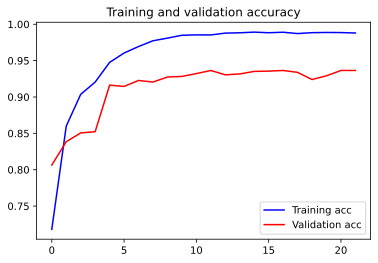

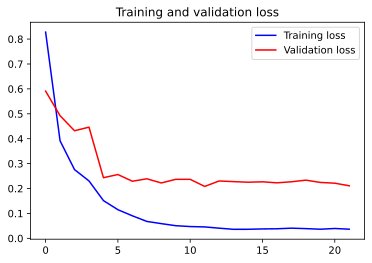

In [41]:
get_history(history)

# Submission

In [42]:
#Clean
test_sub_generator.samples

6675

In [43]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

105/105 [==============================] - 50s 479ms/step


In [44]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')


Save submit


In [45]:
from tqdm import tqdm

In [46]:
#test time augmentation
tta_steps = 20
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(aug_sub_generator, steps=len(aug_sub_generator), verbose = 1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

predictions = np.argmax(pred, axis=-1)

filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('tta_submission.csv', index=False)
print('Save submit')

  0%|          | 0/20 [00:00<?, ?it/s]

105/105 [==============================] - 56s 537ms/step


  5%|▌         | 1/20 [00:57<18:11, 57.44s/it]

105/105 [==============================] - 55s 524ms/step


 10%|█         | 2/20 [01:53<17:06, 57.03s/it]

105/105 [==============================] - 55s 525ms/step


 15%|█▌        | 3/20 [02:49<16:05, 56.80s/it]

105/105 [==============================] - 55s 524ms/step


 20%|██        | 4/20 [03:45<15:05, 56.58s/it]

105/105 [==============================] - 55s 524ms/step


 25%|██▌       | 5/20 [04:41<14:06, 56.41s/it]

105/105 [==============================] - 54s 519ms/step


 30%|███       | 6/20 [05:37<13:05, 56.13s/it]

105/105 [==============================] - 55s 521ms/step


 35%|███▌      | 7/20 [06:33<12:09, 56.11s/it]

105/105 [==============================] - 54s 518ms/step


 40%|████      | 8/20 [07:28<11:10, 55.90s/it]

105/105 [==============================] - 55s 526ms/step


 45%|████▌     | 9/20 [08:25<10:15, 55.99s/it]

105/105 [==============================] - 54s 519ms/step


 50%|█████     | 10/20 [09:20<09:18, 55.85s/it]

105/105 [==============================] - 55s 527ms/step


 55%|█████▌    | 11/20 [10:16<08:23, 55.99s/it]

105/105 [==============================] - 55s 519ms/step


 60%|██████    | 12/20 [11:12<07:26, 55.85s/it]

105/105 [==============================] - 55s 523ms/step


 65%|██████▌   | 13/20 [12:08<06:31, 55.86s/it]

105/105 [==============================] - 54s 516ms/step


 70%|███████   | 14/20 [13:03<05:33, 55.65s/it]

105/105 [==============================] - 55s 521ms/step


 75%|███████▌  | 15/20 [13:59<04:38, 55.66s/it]

105/105 [==============================] - 55s 519ms/step


 80%|████████  | 16/20 [14:54<03:42, 55.61s/it]

105/105 [==============================] - 54s 518ms/step


 85%|████████▌ | 17/20 [15:50<02:46, 55.58s/it]

105/105 [==============================] - 55s 522ms/step


 90%|█████████ | 18/20 [16:46<01:51, 55.73s/it]

105/105 [==============================] - 55s 522ms/step


 95%|█████████▌| 19/20 [17:42<00:55, 55.77s/it]

105/105 [==============================] - 55s 526ms/step


100%|██████████| 20/20 [18:38<00:00, 55.91s/it]

Save submit


In [ ]:
predictions

# Feature Visualization

In [ ]:
#Feature maps visualization
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img(PATH+'/train/0/100380.jpg', target_size = (IMG_SIZE,IMG_SIZE))
imgplot = plt.imshow(img)
plt.show()
img.size

img = img_to_array(img)
img.shape

In [ ]:
from numpy import expand_dims

img = expand_dims(img, axis=0)
feature_maps = model.predict(img)

square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0,:], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [ ]:
feature_maps[0].shape

In [74]:
layer_list = []
for layer in base_model.layers:
    if 'conv' in layer.name:
        layer_list.append(layer.name)
layer_list

['conv1_pad',
 'conv1_conv',
 'conv1_bn',
 'conv1_relu',
 'conv2_block1_1_conv',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_conv',
 'conv2_block1_2_bn',
 'conv2_block1_2_relu',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block1_0_bn',
 'conv2_block1_3_bn',
 'conv2_block1_add',
 'conv2_block1_out',
 'conv2_block2_1_conv',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_conv',
 'conv2_block2_2_bn',
 'conv2_block2_2_relu',
 'conv2_block2_3_conv',
 'conv2_block2_3_bn',
 'conv2_block2_add',
 'conv2_block2_out',
 'conv2_block3_1_conv',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_conv',
 'conv2_block3_2_bn',
 'conv2_block3_2_relu',
 'conv2_block3_3_conv',
 'conv2_block3_3_bn',
 'conv2_block3_add',
 'conv2_block3_out',
 'conv3_block1_1_conv',
 'conv3_block1_1_bn',
 'conv3_block1_1_relu',
 'conv3_block1_2_conv',
 'conv3_block1_2_bn',
 'conv3_block1_2_relu',
 'conv3_block1_0_conv',
 'conv3_block1_3_conv',
 'conv3_block1_0_bn',
 'c

In [90]:
# попытка визуализировать на что реагирует слой, не доработано

fig, axs = plt.subplots(43, 4, figsize=(100,100))

epochs = 100
step_size = 1.
filter_index = 0
i = 0
j = 0

for name in layer_list:

    # Create a connection between the input and the target layer
    submodel = tf.keras.models.Model([base_model.inputs[0]], [base_model.get_layer(layer_list[i]).output])

    # Initiate random noise
    input_img_data = np.random.random((1, 224, 224, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128.

    # Cast random noise from np.float64 to tf.float32 Variable
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    # Iterate gradient ascents
    for _ in range(epochs):
        with tf.GradientTape() as tape:
            outputs = submodel(input_img_data)
            loss_value = tf.reduce_mean(outputs[:, filter_index])
        grads = tape.gradient(loss_value, input_img_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data.assign_add(normalized_grads * step_size)
    input_img_data = input_img_data.numpy().astype(np.uint8)
    if j == 4:
        j=0
        i+=1
    axs[i, j].imshow(input_img_data[0])
    j+=1